### start

In [3]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.evaluation_orchestrator as eo
import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import wallet_insights.wallet_validation_analysis as wiva
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    eo, sime,
    wm, sm, wo,
    h,
    wime, wiva,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[14/Aug/25 12:53:46] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[14/Aug/25 12:53:46] MILESTONE [2680403529.<module>:138] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

#### load all local data

In [9]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[11/Aug/25 23:43:52] INFO [workflow_orchestrator.load_all_training_data:101] Auto-detected date_suffixes from config: ['210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '220715', '220814', '220913', '221013', '221112', '221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240205', '240306', '240405', '240505', '240604', '240704', '240803', '241002', '241201', '250130', '250331', '240902', '241101', '241231', '250301', '250430', '250530']
[11/Aug/25 23:43:52] MILESTONE [workflow_orchestrator.load_all_training_data:118] <PROD> Loading training data for 52 periods: ['210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '220715', '220814', '220913', '221013', '221112', '221212', '230111', '23

#### preprocess and concatenate

In [10]:
results = workflow_orch.preprocess_all_training_data()

[11/Aug/25 23:44:00] INFO [workflow_orchestrator.preprocess_all_training_data:156] Preprocessing 52 date periods...
[11/Aug/25 23:44:00] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_train.
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._save_preprocessed_df:418] Saved preprocessed train to ../s3_uploads/wallet_training_data_preprocessed/dda_957_coin_model/210322/train.parquet
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._save_preprocessed_df:418] Saved preprocessed train_y to ../s3_uploads/wallet_training_data_preprocessed/dda_957_coin_model/210322/train_y.parquet
[11/Aug/25 23:44:00] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 60,736 rows × 231 cols.
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_test.


In [11]:
workflow_orch.concatenate_all_preprocessed_data()

[11/Aug/25 23:44:39] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:194] Loading preprocessed training data...
[11/Aug/25 23:44:43] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:197] Beginning concatenation of preprocessed data from Parquet...
[11/Aug/25 23:44:44] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated train_index.parquet with 1148070 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/train_index.parquet
[11/Aug/25 23:50:10] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:267] Saved concatenated train.csv.gz with 1148070 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/train.csv.gz
[11/Aug/25 23:50:10] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated eval_index.parquet with 44811 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/eval_index.parquet
[11/Aug/25 23:50:22] INFO [workflow_or

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
local_dir = f"{local_dir}_dev" if sage_wallets_config['training_data']['dataset'] == 'dev' else local_dir
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [12]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[11/Aug/25 23:54:34] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[11/Aug/25 23:54:34] INFO [workflow_orchestrator.upload_concatenated_training_data:380] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Uploading concatenated splits in parallel with 4 threads...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-957-coin-model/train.csv.gz'...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-957-coin-model/val.csv.gz'...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/d

### Epoch Shifts Sequence

#### train all epoch shifts

In [80]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[13/Aug/25 18:32:33] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[13/Aug/25 18:32:33] INFO [workflow_orchestrator.upload_concatenated_training_data:386] Uploading concatenated splits in parallel with 4 threads...
[13/Aug/25 18:32:33] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-956-importance/train.csv.gz
[13/Aug/25 18:32:33] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-956-importance/test.csv.gz
[13/Aug/25 18:32:33] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-956-importance/eval.csv.gz
[13/Aug/25 18:32:33] INFO [workflow_orchestrator._upload_split:400] File 

2025-08-14 01:32:37 Starting - Starting the training job2025-08-14 01:32:39 Starting - Starting the training job..2025-08-14 01:32:37 Starting - Starting the training job.2025-08-14 01:32:41 Starting - Starting the training job.2025-08-14 01:32:42 Starting - Starting the training job.2025-08-14 01:32:41 Starting - Starting the training job.2025-08-14 01:32:43 Starting - Starting the training job...............
2025-08-14 01:33:07 Downloading - Downloading input data
2025-08-14 01:32:54 Starting - Preparing the instances for training..
2025-08-14 01:33:09 Downloading - Downloading input data.
2025-08-14 01:32:56 Starting - Preparing the instances for training.
2025-08-14 01:33:13 Downloading - Downloading input data.
2025-08-14 01:33:11 Downloading - Downloading input data.
2025-08-14 01:33:14 Downloading - Downloading input data...............
2025-08-14 01:33:15 Downloading - Downloading input data...
2025-08-14 01:33:13 Downloading - Downloading input data..................
2025-08-1

[13/Aug/25 18:37:30] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-183233/output/model.tar.gz
[13/Aug/25 18:37:30] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=360


[176]#011eval-aucpr:0.27102
[177]#011eval-aucpr:0.27089
[178]#011eval-aucpr:0.27056
[179]#011eval-aucpr:0.26998
[180]#011eval-aucpr:0.26955
[181]#011eval-aucpr:0.27003
[182]#011eval-aucpr:0.27019
[183]#011eval-aucpr:0.26966

2025-08-14 01:37:33 Uploading - Uploading generated training model
2025-08-14 01:37:33 Completed - Training job completed

2025-08-14 01:37:39 Uploading - Uploading generated training model
2025-08-14 01:37:39 Completed - Training job completed

2025-08-14 01:37:39 Uploading - Uploading generated training model
2025-08-14 01:37:39 Completed - Training job completed

2025-08-14 01:37:33 Uploading - Uploading generated training model
2025-08-14 01:37:33 Completed - Training job completed

2025-08-14 01:37:36 Uploading - Uploading generated training model
2025-08-14 01:37:36 Completed - Training job completed

2025-08-14 01:37:29 Completed - Training job completed
Training seconds: 265
Billable seconds: 265


[13/Aug/25 18:37:59] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-183233/output/model.tar.gz
[13/Aug/25 18:37:59] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=120


Training seconds: 270
Billable seconds: 270


[13/Aug/25 18:38:00] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-183233/output/model.tar.gz
[13/Aug/25 18:38:00] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=60


Training seconds: 265
Billable seconds: 265


[13/Aug/25 18:38:01] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-183233/output/model.tar.gz
[13/Aug/25 18:38:01] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=0


Training seconds: 260
Billable seconds: 260


[13/Aug/25 18:38:02] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-183233/output/model.tar.gz
[13/Aug/25 18:38:02] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=300


Training seconds: 265
Billable seconds: 265


[13/Aug/25 18:38:03] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-183233/output/model.tar.gz
[13/Aug/25 18:38:03] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=240


Training seconds: 255
Billable seconds: 255


[13/Aug/25 18:38:04] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-183233/output/model.tar.gz
[13/Aug/25 18:38:04] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=180
[13/Aug/25 18:38:04] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:519] Epoch shift training complete: 7/7 models successful


#### predict all epoch_shifts

In [7]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)

[14/Aug/25 11:54:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials


[14/Aug/25 11:54:11] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:696] Starting predictions for 1 epoch shifts using 15 threads...
[14/Aug/25 11:54:11] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-220502): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-220502/output/model.tar.gz
[14/Aug/25 11:54:11] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[14/Aug/25 11:54:11] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[14/Aug/25 11:54:11] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-220502
[14/Aug/25 11:54:11] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-220502
[14/Aug/25 11:54:12] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh0-0813-220502
[14/Aug/25 11:54:12] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh0-081

........................................................................................................................................!

[14/Aug/25 12:00:02] INFO [wallet_modeler._execute_batch_transform:666] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-115412-concat-test/test.csv.gz.out



.

[14/Aug/25 12:00:03] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh0/test.csv.out.
[14/Aug/25 12:00:03] INFO [wallet_modeler.None:296] (5m51s) Completed predict_with_batch_transform.


.............................!

[14/Aug/25 12:02:34] INFO [wallet_modeler._execute_batch_transform:666] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-115412-concat-val/val.csv.gz.out


[14/Aug/25 12:02:36] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh0/val.csv.out.
[14/Aug/25 12:02:36] INFO [wallet_modeler.None:296] (8m24s) Completed predict_with_batch_transform.
[14/Aug/25 12:02:36] INFO [wallet_modeler.None:358] (8m24s) Completed batch_predict_test_and_val.
[14/Aug/25 12:02:36] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=0
[14/Aug/25 12:02:36] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:730] Epoch shift predictions complete: 1/1 successful


{0: {'test': {'transform_job_name': 'wallet-scoring-sh0-115412-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-115412-concat-test/test.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-956-importance/test.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh0-115412-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-115412-concat-val/val.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-956-importance/val.csv.gz'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-220502/output/model.tar.gz',
  'training_job_name': 'wscr-dda-956--sh0-0813-220502',
  'epoch_shift': 0}}

In [2]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)

[14/Aug/25 12:02:48] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 12:02:49] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:696] Starting predictions for 1 epoch shifts using 15 threads...
[14/Aug/25 12:02:49] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-220502): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-220502/output/model.tar.gz
[14/Aug/25 12:02:49] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[14/Aug/25 12:02:49] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[14/Aug/25 12:02:49] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-220502
[14/Aug/25 12:02:49] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-220502
[14/Aug/25 12:02:50] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh0

{0: {'error': 'An error occurred (ValidationException) when calling the CreateTransformJob operation: Invalid InputFilter: "$[?(@[0] in [1410, 1440, 1470, 1500, 1530, 1560])][1:]". Unexpected "?" in JsonPath. Supported operators for "text/csv" are [\'$\', \'[\', \']\', \'*\', \' \', \',\', \':\', \'-\'].'}}

#### evaluate importances

In [ ]:
# Import and reload modules (your existing pattern)
[importlib.reload(module) for module in modules]

# Load configs (your existing pattern)
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Create evaluation orchestrator
import sage_wallet_insights.evaluation_orchestrator as eo
eval_orch = eo.EvaluationOrchestrator(sage_wallets_config, sage_wallets_modeling_config)
complete_importance_data = eval_orch.generate_all_feature_importances()

[13/Aug/25 18:14:52] MILESTONE [evaluation_orchestrator.generate_all_feature_importances:79] Generating feature importances for 7 epoch shifts...
[13/Aug/25 18:14:53] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:53] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:53] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:53] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0

In [ ]:
# w regularization
feature_categories_filter = [
    # 'macro',
    # 'cw_coin_trends',
    # 'timing',
    # etc.
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.filter_and_aggregate_importances(
    feature_categories_filter=feature_categories_filter,
    # feature_names_filter=feature_names_filter,
    groups=groups,
    complete_df=complete_importance_data
)

# View results
all_importance_stats.head(20)

In [77]:
# 2 years less
feature_categories_filter = [
    # 'macro',
    # 'cw_coin_trends',
    # 'timing',
    # etc.
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.filter_and_aggregate_importances(
    feature_categories_filter=feature_categories_filter,
    # feature_names_filter=feature_names_filter,
    groups=groups,
    complete_df=complete_importance_data
)

# View results
all_importance_stats.head(20)

[13/Aug/25 18:14:54] INFO [evaluation_orchestrator.filter_and_aggregate_importances:208] Filtered importance analysis: 18 feature groups across 7 models


model_count  pct_mean  pct_median  pct_min  pct_max  \
feature_category                                                        
macro                       7    0.4181      0.3898   0.3068   0.6183   
cw_coin_trends              7    0.2497      0.2589   0.1529   0.3307   
cw_mktcap                   7    0.0738      0.0737   0.0562   0.1115   
cw_scenario                 7    0.0555      0.0505   0.0268   0.0953   
timing                      7     0.041      0.0419   0.0234   0.0515   
transfers                   7    0.0311      0.0329     0.02   0.0381   
cw_transfers                7     0.026      0.0265   0.0165   0.0314   
scenario                    7    0.0213      0.0229   0.0138   0.0288   
cw_trading                  7    0.0163      0.0155   0.0086   0.0222   
cw_performance              7    0.0147      0.0164   0.0082   0.0186   
trading                     7    0.0132      0.0128   0.0092   0.0194   
cw_timing                   7    0.0109      0.0112   0.0032   0.0165   
cw_cluster                  6    0.0101       0.009   0.0012    0.026   
performance                 7    0.0098      0.0122   0.0037   0.0138   
mktcap                      7    0.0055      0.0057   0.0035   0.0065   
cluster                     4    0.0025      0.0028   0.0009   0.0036   
cw_balance                  7    0.0016      0.0015   0.0012    0.002   
balance                     7    0.0013      0.0013   0.0009   0.0019   

                  pct_std  total_importance_sum  importance_mean  
feature_category                                                  
macro              0.0991              45595.42          6513.63  
cw_coin_trends     0.0541              24790.48           3541.5  
cw_mktcap          0.0191               7672.78          1096.11  
cw_scenario        0.0211               5514.87           787.84  
timing             0.0096               4041.42           577.35  
transfers          0.0056                3111.8           444.54  
cw_transfers       0.0052               2591.78           370.25  
scenario           0.0049               2117.59           302.51  
cw_trading         0.0046               1707.91           243.99  
cw_performance     0.0037               1454.12           207.73  
trading            0.0036               1343.59           191.94  
cw_timing          0.0042               1038.99           148.43  
cw_cluster         0.0085                842.61           140.44  
performance        0.0041                968.15           138.31  
mktcap              0.001                552.73            78.96  
cluster            0.0013                144.02            36.01  
cw_balance         0.0003                 157.3            22.47  
balance            0.0004                129.37            18.48

In [ ]:
feature_categories_filter = [
    # 'macro',
    # 'cw_coin_trends',
    # 'timing',
    # etc.
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.filter_and_aggregate_importances(
    feature_categories_filter=feature_categories_filter,
    # feature_names_filter=feature_names_filter,
    groups=groups,
    complete_df=complete_importance_data
)

# View results
all_importance_stats.head(20)

[13/Aug/25 17:32:50] INFO [evaluation_orchestrator.filter_and_aggregate_importances:208] Filtered importance analysis: 18 feature groups across 7 models


model_count  pct_mean  pct_median  pct_min  pct_max  \
feature_category                                                        
macro                       7    0.5731      0.5626   0.4734   0.7312   
cw_coin_trends              7    0.2093      0.1728    0.145   0.2889   
cw_scenario                 7    0.0665      0.0587   0.0306   0.1152   
cw_mktcap                   7    0.0338      0.0304   0.0224    0.057   
cw_trading                  7    0.0193      0.0201   0.0125   0.0288   
cw_transfers                7    0.0157      0.0159   0.0031    0.027   
transfers                   7    0.0157      0.0162   0.0048   0.0247   
cw_cluster                  4    0.0146      0.0091   0.0003     0.04   
timing                      7    0.0138      0.0074   0.0011   0.0346   
trading                     7    0.0129      0.0117   0.0066   0.0259   
cw_performance              7    0.0121      0.0098   0.0089   0.0169   
scenario                    7     0.008      0.0036   0.0004   0.0174   
cw_timing                   4    0.0079      0.0084   0.0039   0.0109   
performance                 7    0.0033      0.0037   0.0002   0.0069   
cluster                     2    0.0021      0.0021   0.0019   0.0022   
mktcap                      6    0.0019       0.002   0.0003   0.0036   
balance                     5     0.001       0.001   0.0002   0.0017   
cw_balance                  5    0.0009      0.0012   0.0003   0.0014   

                  pct_std  total_importance_sum  importance_mean  
feature_category                                                  
macro              0.0791             197757.31         28251.04  
cw_coin_trends     0.0602              68137.74          9733.96  
cw_scenario        0.0276              21505.32          3072.19  
cw_mktcap          0.0118              10865.39           1552.2  
cw_trading         0.0058               6072.97           867.57  
cw_transfers       0.0095               4564.55           652.08  
transfers          0.0084               4237.21           605.32  
cw_cluster         0.0177               2016.05           504.01  
timing             0.0136               3124.45           446.35  
trading            0.0064               4136.11           590.87  
cw_performance     0.0036               4162.39           594.63  
scenario            0.008               1849.64           264.23  
cw_timing          0.0032                970.46           242.62  
performance        0.0026                854.45           122.06  
cluster            0.0002                107.09            53.55  
mktcap             0.0016                 372.2            62.03  
balance            0.0006                168.91            33.78  
cw_balance         0.0005                 145.7            29.14

#### evaluate all epoch shifts

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()


[13/Aug/25 18:14:54] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:749] Building evaluators for 7 epoch shifts using 6 threads...
[13/Aug/25 18:14:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-175145/output/model.tar.gz
[13/Aug/25 18:14:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp:

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 60 shift: [1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620]
Starting with 160,510 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 11,169,836
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 19,651 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 19,651 rows (140,859 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 6
  Max: 967,754,176
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 55,429 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_fi

[13/Aug/25 18:16:28] INFO [model_evaluation.None:425] (1m24s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 176,272 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 10,752,532
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 36,119 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 36,119 rows (140,153 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 956,730,112
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 56,172 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 40,496 rows (99,657 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 343
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 55,176 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 30,541 rows (69,116 remaining)
Custom filtering complete: 107,156 rows removed (60.8%), 69,116 rows remaining
Unique offset_date values in data: [1230.

[13/Aug/25 18:16:32] INFO [model_evaluation.None:425] (1m28s) Completed _apply_custom_transforms_to_concatenated_data.


Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 300 shift: [1890, 1920]
Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 240 shift: [1830, 1860]
Starting with 119,347 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
Starting with 283,340 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Max: 9,878,339
  Min: 0
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 30,759 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 30,759 rows (88,588 remaining)
Column stats

[13/Aug/25 18:16:33] INFO [model_evaluation.None:425] (1m28s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 18:16:33] INFO [model_evaluation.None:425] (1m29s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 18:16:33] INFO [model_evaluation.None:425] (1m29s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 171,623 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,063,788
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 33,197 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 33,197 rows (138,426 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,253
  Max: 929,659,456
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 47,694 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 34,470 rows (103,956 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 349
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 54,408 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 33,102 rows (70,854 remaining)
Custom filtering complete: 100,769 rows removed (58.7%), 70,854 rows remaining
Starting with 251,656 rows before cu

[13/Aug/25 18:16:33] INFO [model_evaluation.None:425] (1m29s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 18:18:14] INFO [model_evaluation.None:36] (3m10s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 18:18:14] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=60
[13/Aug/25 18:18:14] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-175145): s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-175145/output/model.tar.gz
[13/Aug/25 18:18:15] INFO [model_evaluation.None:36] (3m10s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 18:18:15] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=300
[13/Aug/25 18:18:15] INFO [model_evaluation.None:36] (3m11s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 18:18:15] MILESTONE [workflo

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890, 1920]
Starting with 214,455 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,403,229
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 32,643 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 32,643 rows (181,812 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,022
  Max: 996,896,256
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 68,141 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_c

[13/Aug/25 18:18:56] INFO [model_evaluation.None:425] (36.2s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 18:19:43] INFO [model_evaluation.None:36] (1m23s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 18:19:43] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=360
[13/Aug/25 18:19:43] INFO [workflow_orchestrator.None:735] (4m49s) Completed build_all_epoch_shift_evaluators.


In [ ]:
# w regularization
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[13/Aug/25 18:19:44] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:44] WARNING [951596577.<module>:6]                 0: 2024-06-04
[13/Aug/25 18:19:44] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:44] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-175145/output/model.tar.gz
Test Samples:             52,089
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.542  |  0.723
Val Accuracy:               0.819  |  0.831
Val Precision:              0.061  |  0.409
Val Recall:                 0.199  |  0.401
Val F1 Score:               0.093  |  0.405

Validation Returns 

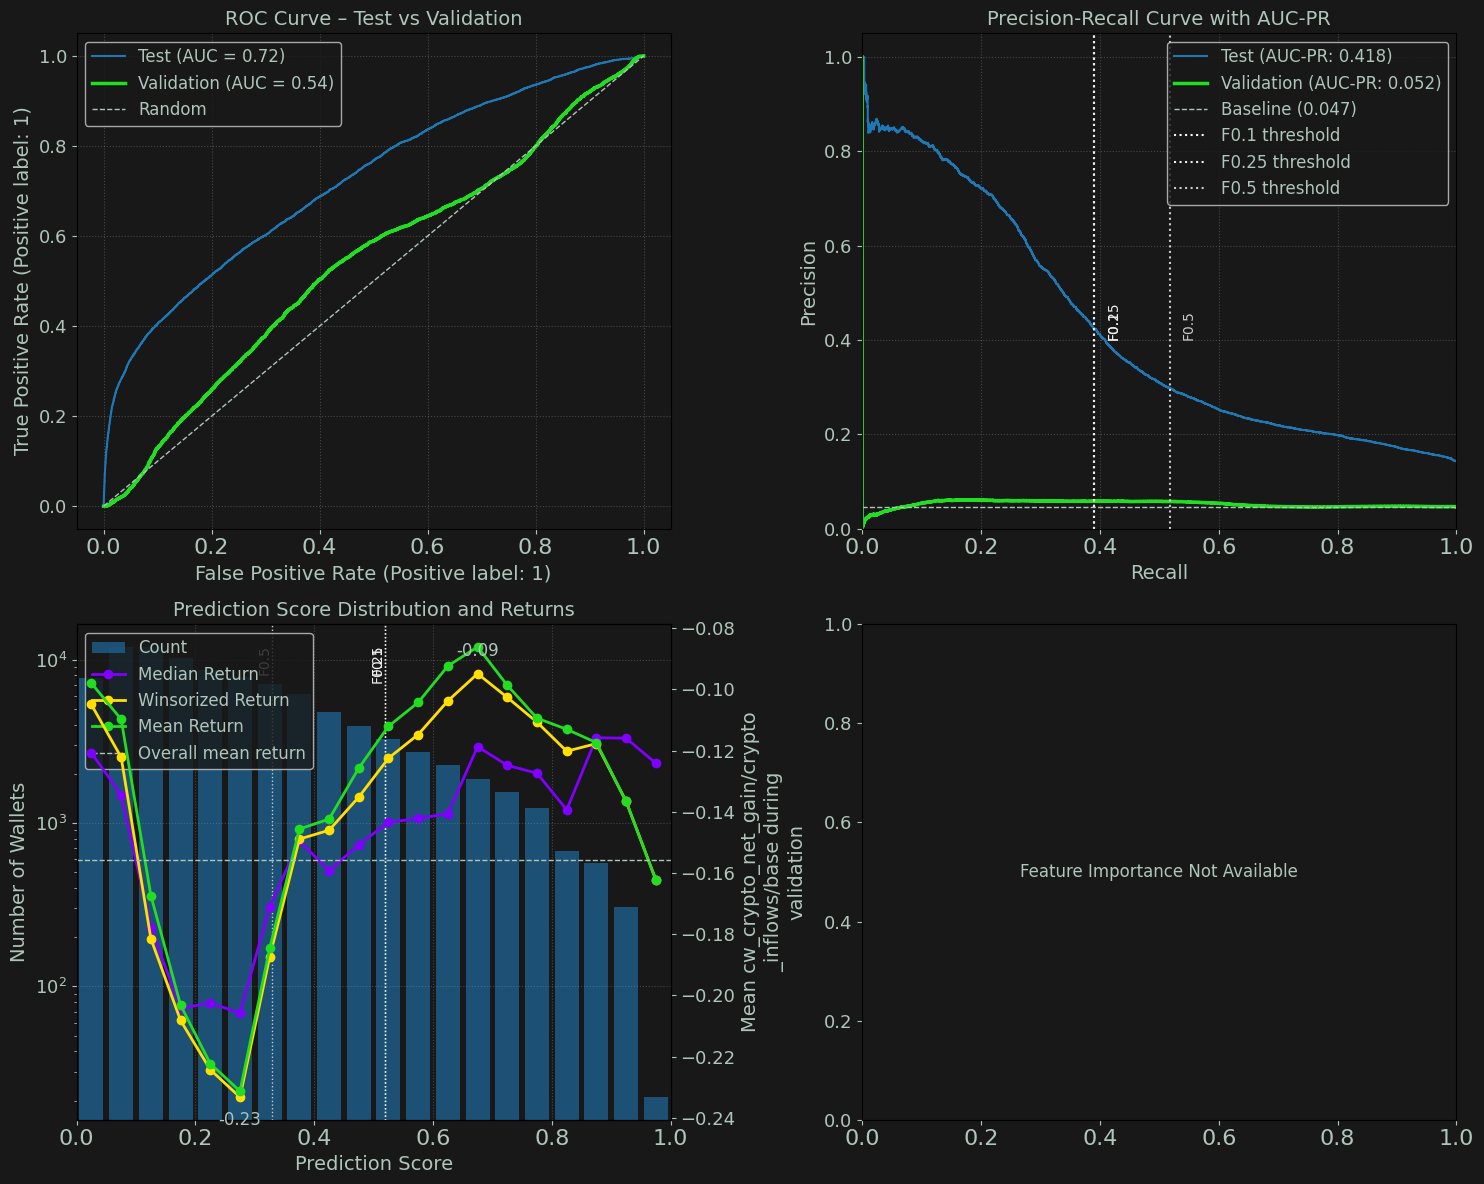

[13/Aug/25 18:19:45] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:45] WARNING [951596577.<module>:6]                 60: 2024-08-03
[13/Aug/25 18:19:45] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:45] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-175145/output/model.tar.gz
Test Samples:             62,474
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.533  |  0.651
Val Accuracy:               0.790  |  0.826
Val Precision:              0.260  |  0.333
Val Recall:                 0.125  |  0.365
Val F1 Score:               0.169  |  0.348

Validation Ret

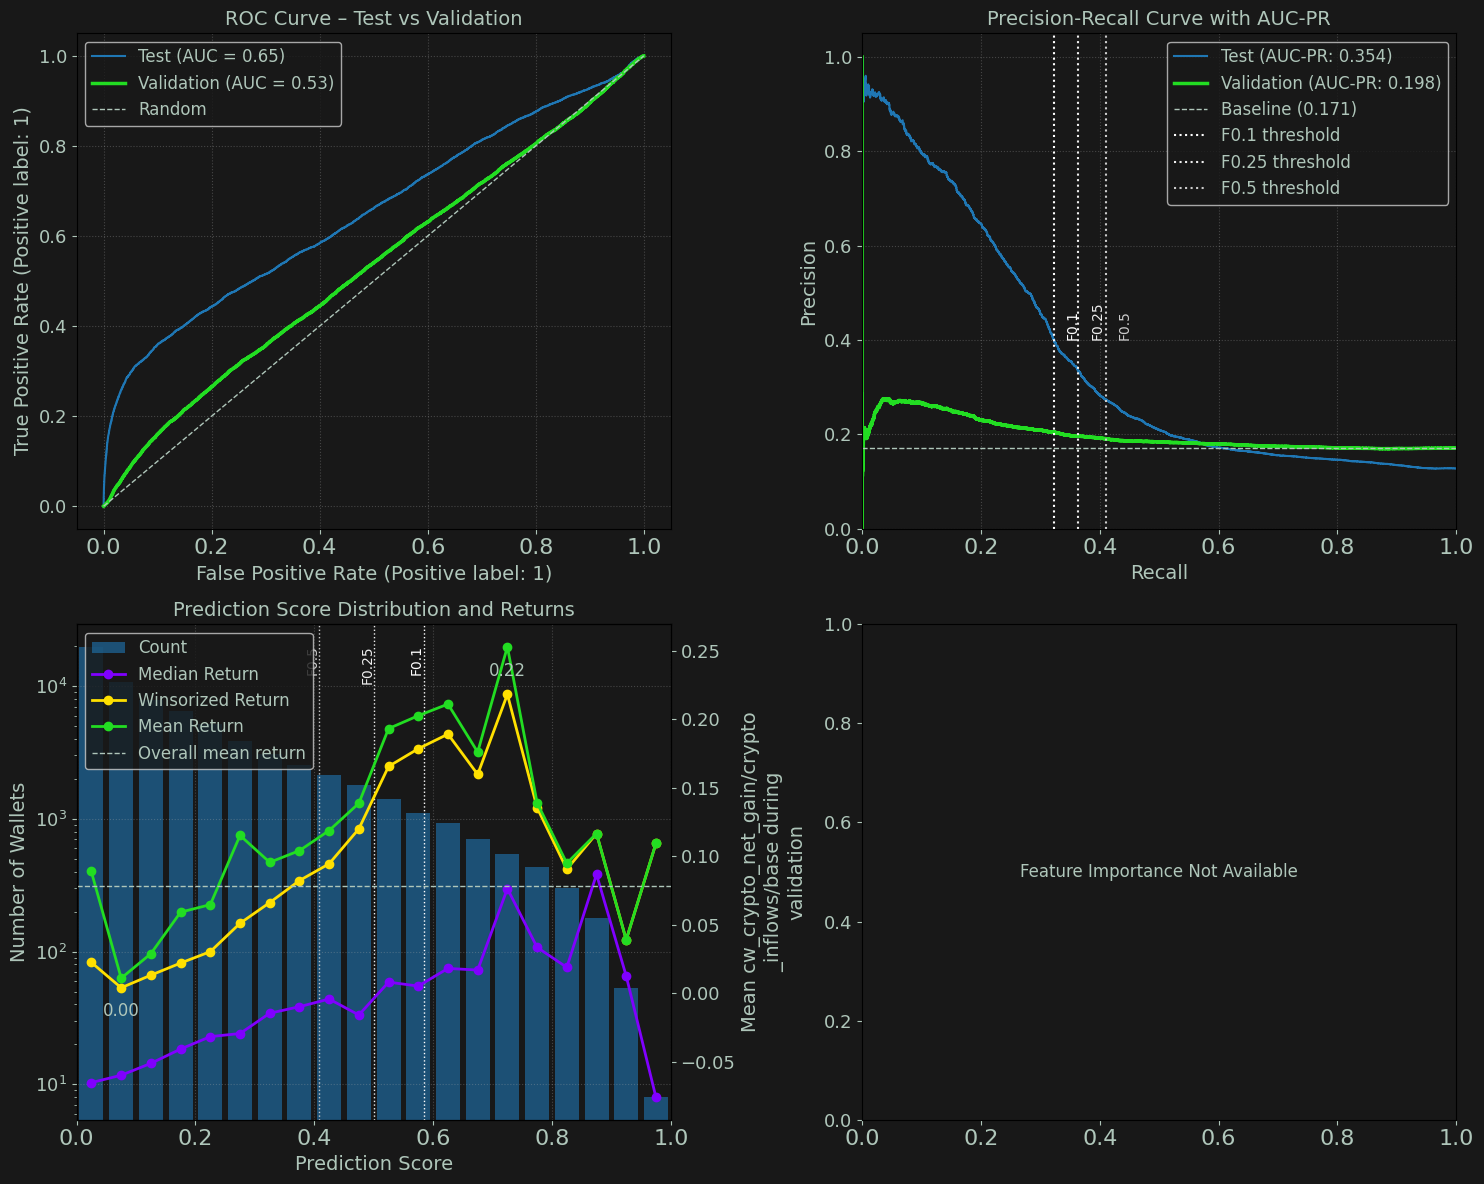

[13/Aug/25 18:19:45] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:45] WARNING [951596577.<module>:6]                 120: 2024-10-02
[13/Aug/25 18:19:45] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:45] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-175145/output/model.tar.gz
Test Samples:             69,591
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.419  |  0.607
Val Accuracy:               0.631  |  0.836
Val Precision:              0.178  |  0.367
Val Recall:                 0.072  |  0.289
Val F1 Score:               0.103  |  0.323

Validation 

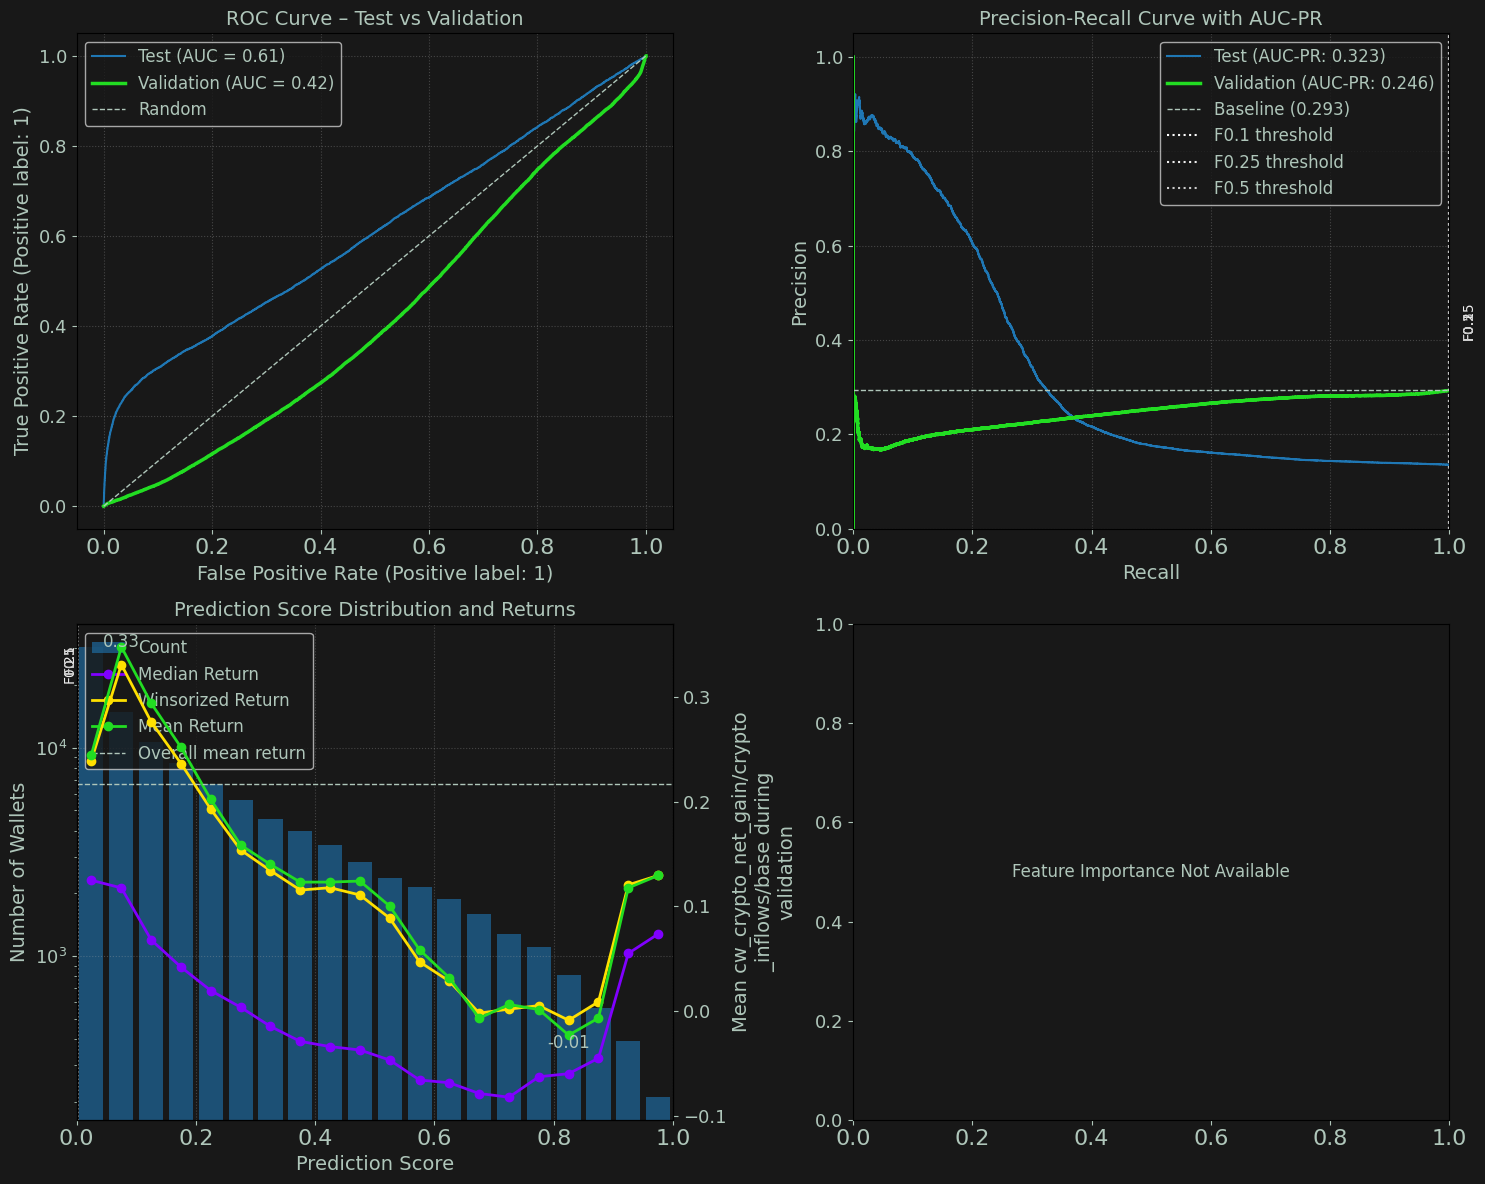

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 180: 2024-12-01
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-175145/output/model.tar.gz
Test Samples:             82,008
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.521  |  0.556
Val Accuracy:               0.830  |  0.797
Val Precision:              0.088  |  0.341
Val Recall:                 0.118  |  0.213
Val F1 Score:               0.101  |  0.262

Validation R

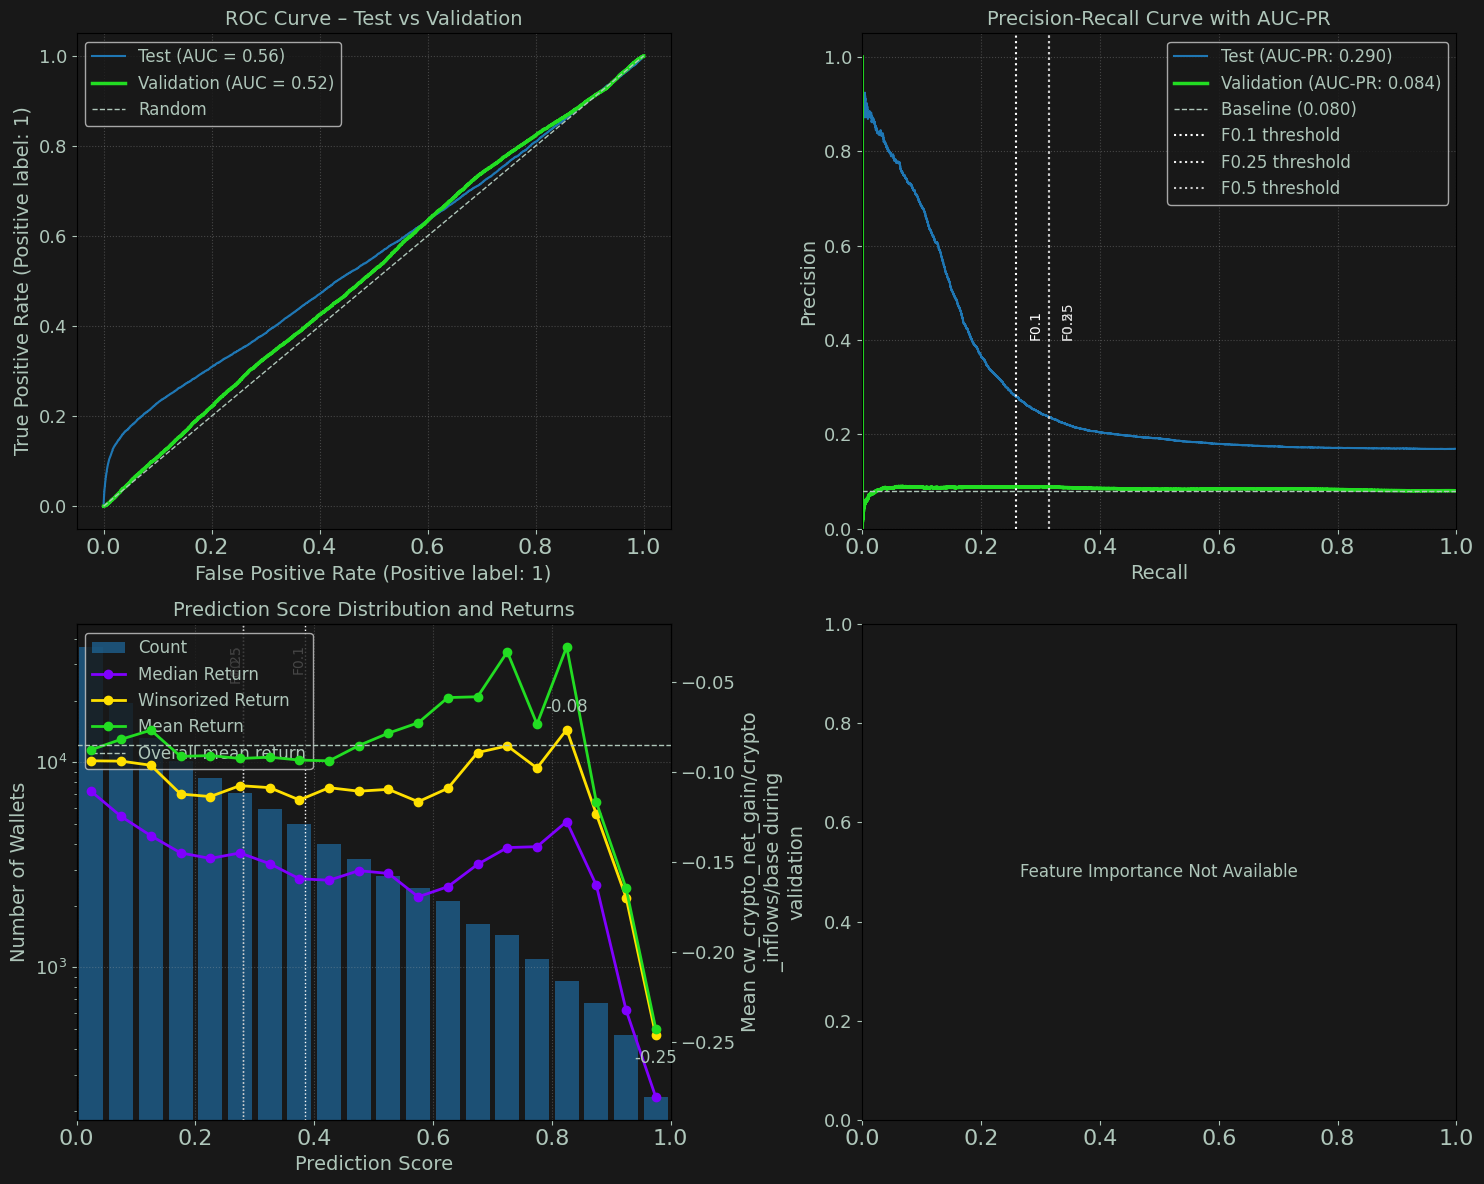

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 240: 2025-01-30
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-175145/output/model.tar.gz
Test Samples:             96,423
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.558  |  0.585
Val Accuracy:               0.951  |  0.789
Val Precision:              0.007  |  0.267
Val Recall:                 0.011  |  0.248
Val F1 Score:               0.009  |  0.257

Validation Re

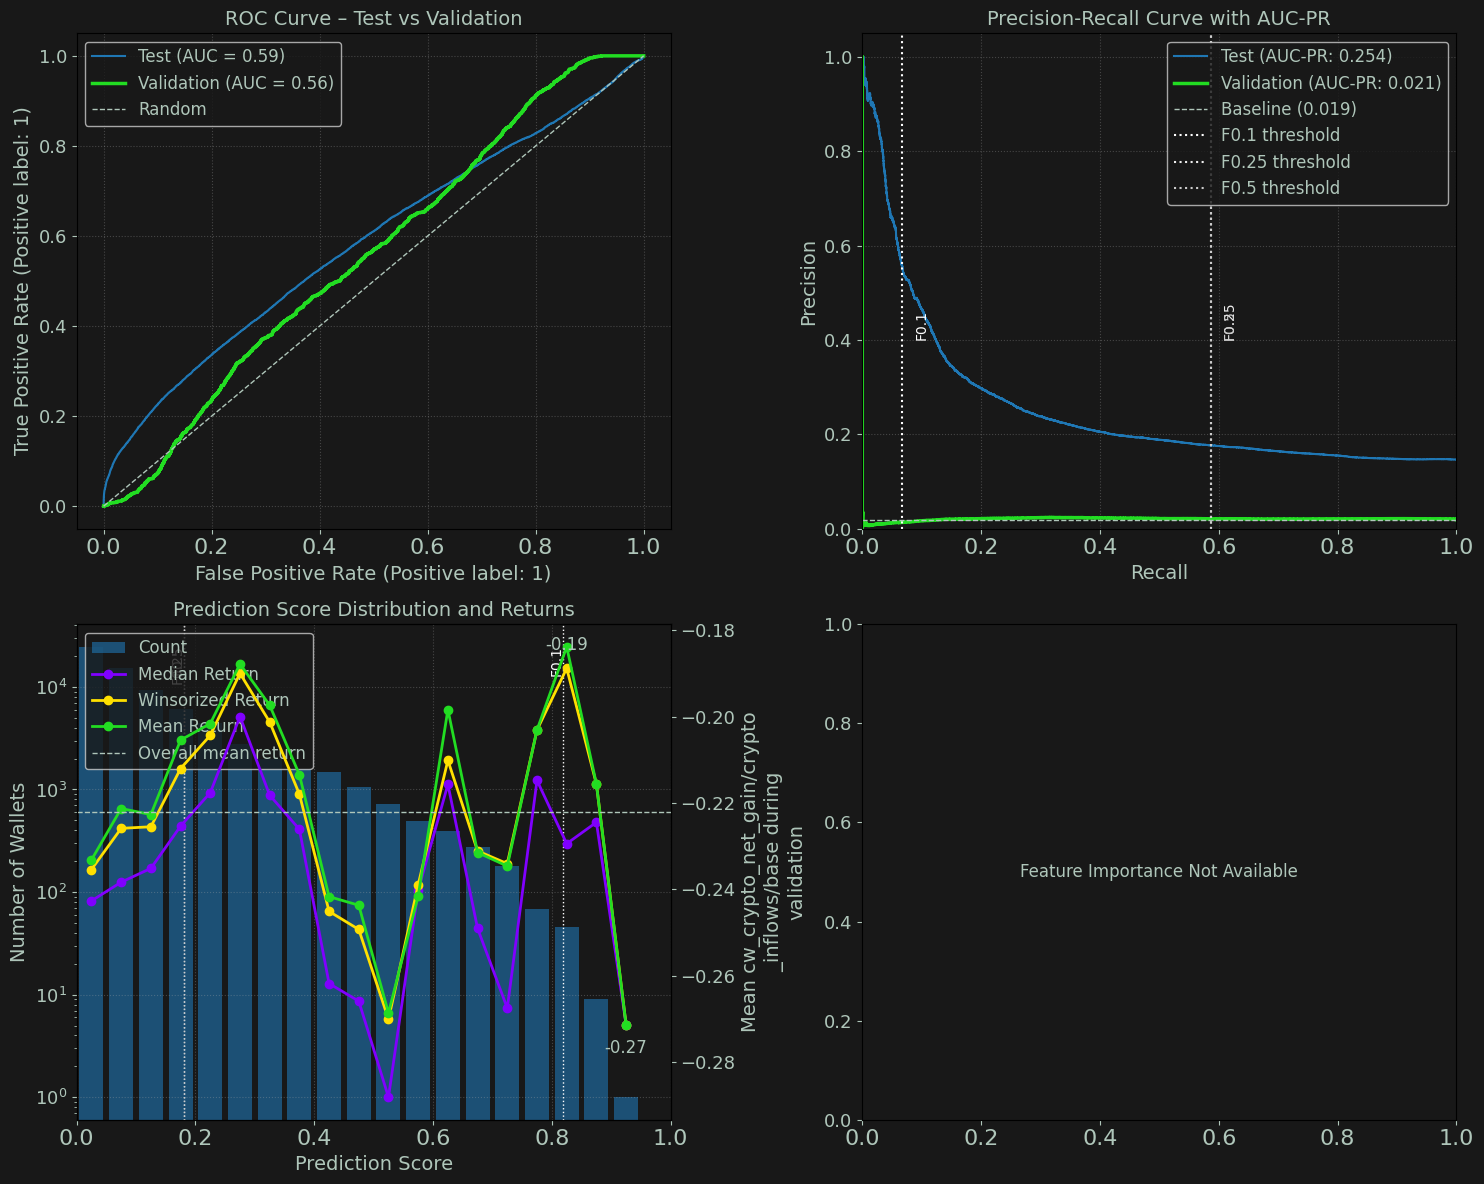

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 300: 2025-03-31
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-175145/output/model.tar.gz
Test Samples:             98,144
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.537  |  0.529
Val Accuracy:               0.754  |  0.807
Val Precision:              0.255  |  0.237
Val Recall:                 0.171  |  0.179
Val F1 Score:               0.205  |  0.204

Validation R

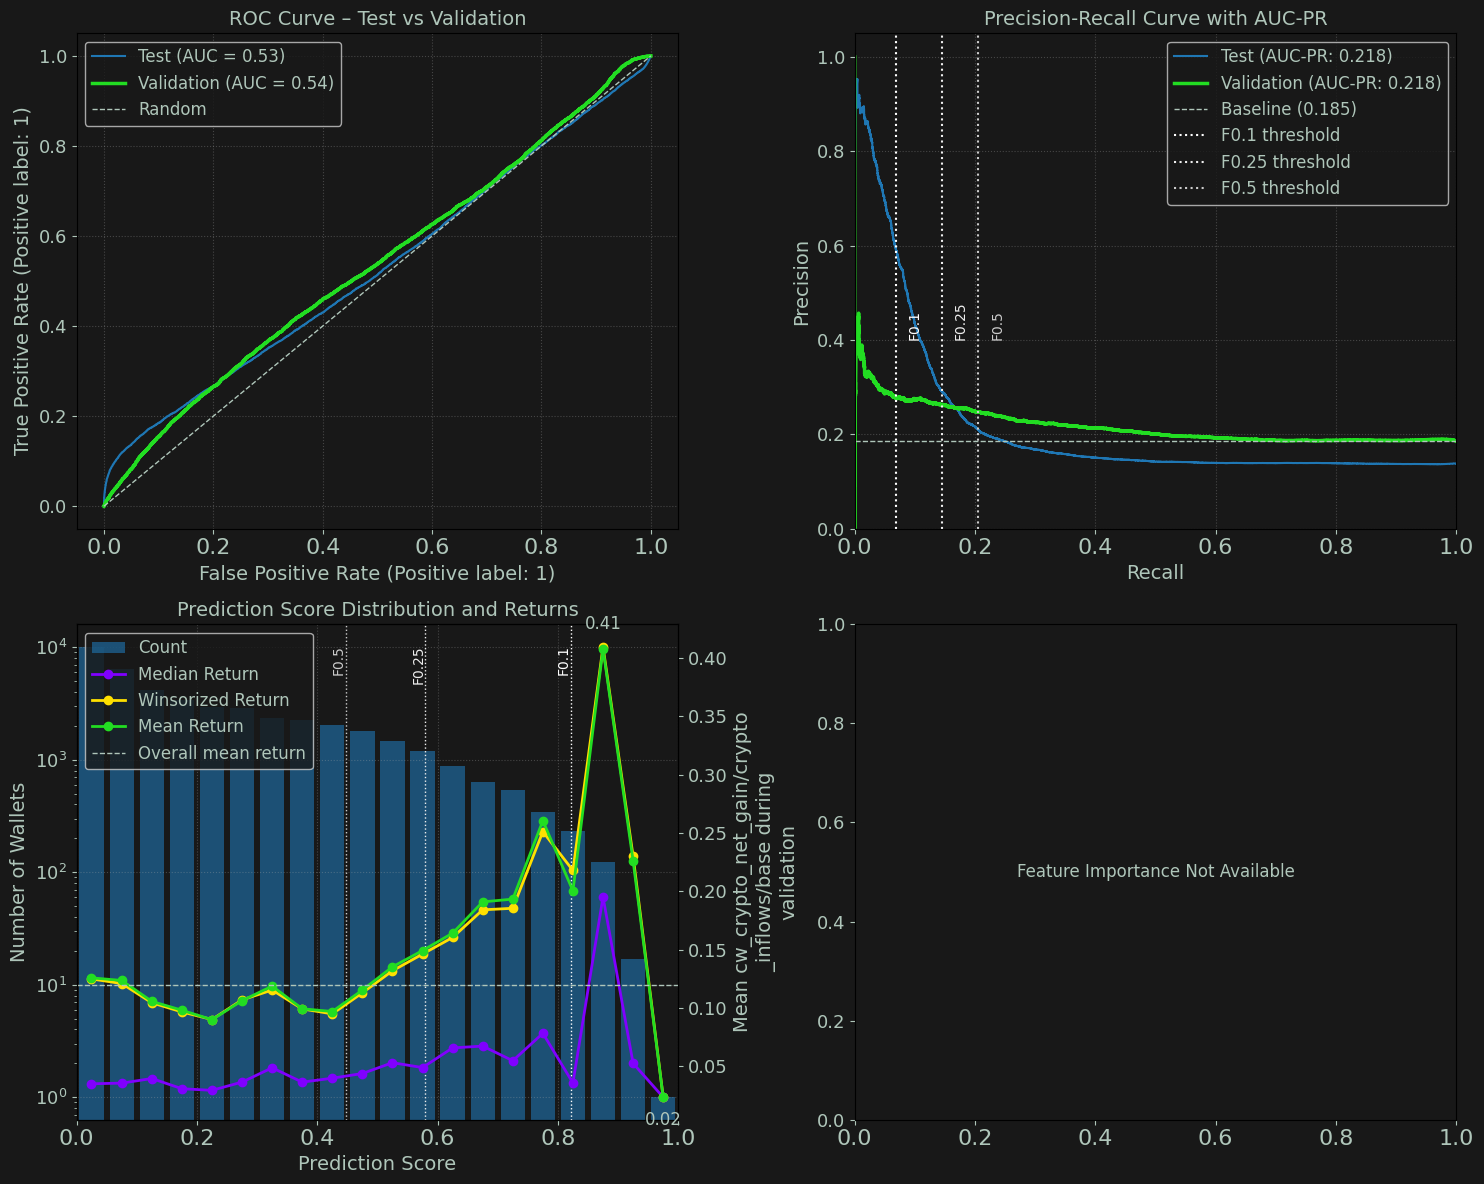

[13/Aug/25 18:19:47] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:47] WARNING [951596577.<module>:6]                 360: 2025-05-30
[13/Aug/25 18:19:47] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:47] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-175145/output/model.tar.gz
Test Samples:             87,938
Val Positive Samples:     6,688 (15.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.577  |  0.526
Val Accuracy:               0.827  |  0.842
Val Precision:              0.183  |  0.144
Val Recall:                 0.034  |  0.081
Val F1 Score:               0.057  |  0.104

Validation R

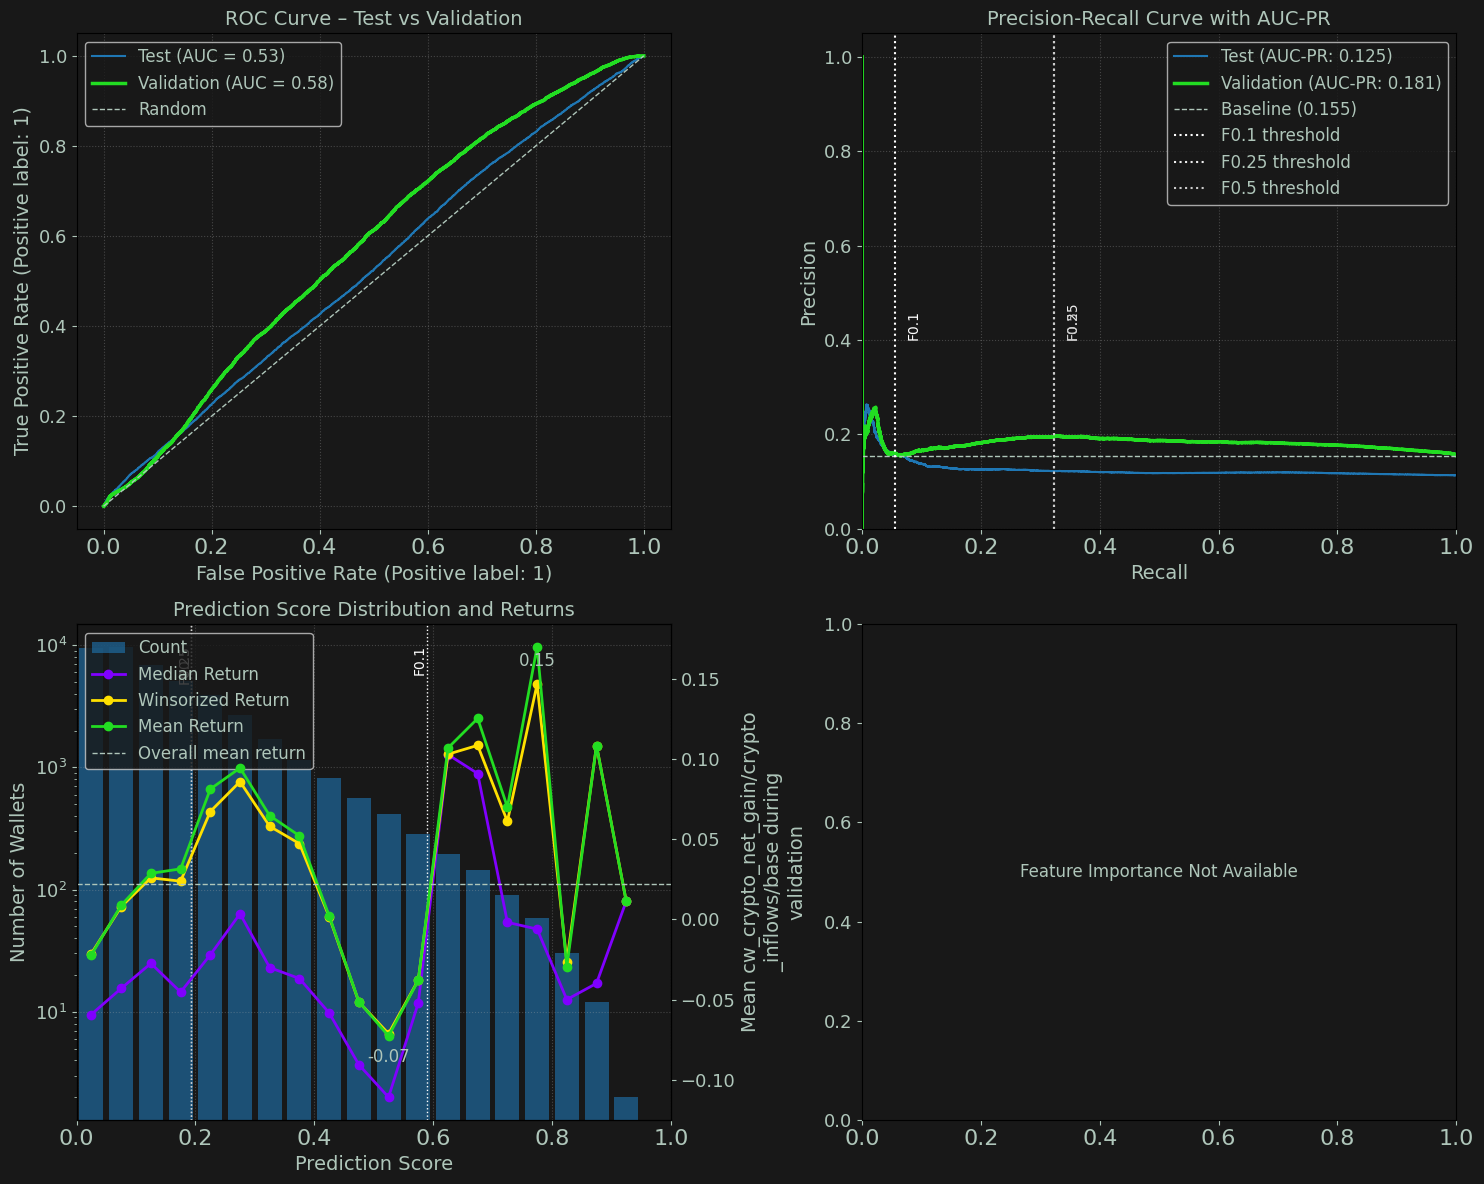

In [79]:
# 2 years less
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[13/Aug/25 17:44:17] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:17] WARNING [1138767417.<module>:5]                 0: 2024-06-04
[13/Aug/25 17:44:17] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:17] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-164642/output/model.tar.gz
Test Samples:             52,089
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.666
Val Accuracy:               0.716  |  0.819
Val Precision:              0.042  |  0.374
Val Recall:                 0.236  |  0.389
Val F1 Score:               0.072  |  0.381

Validation Retur

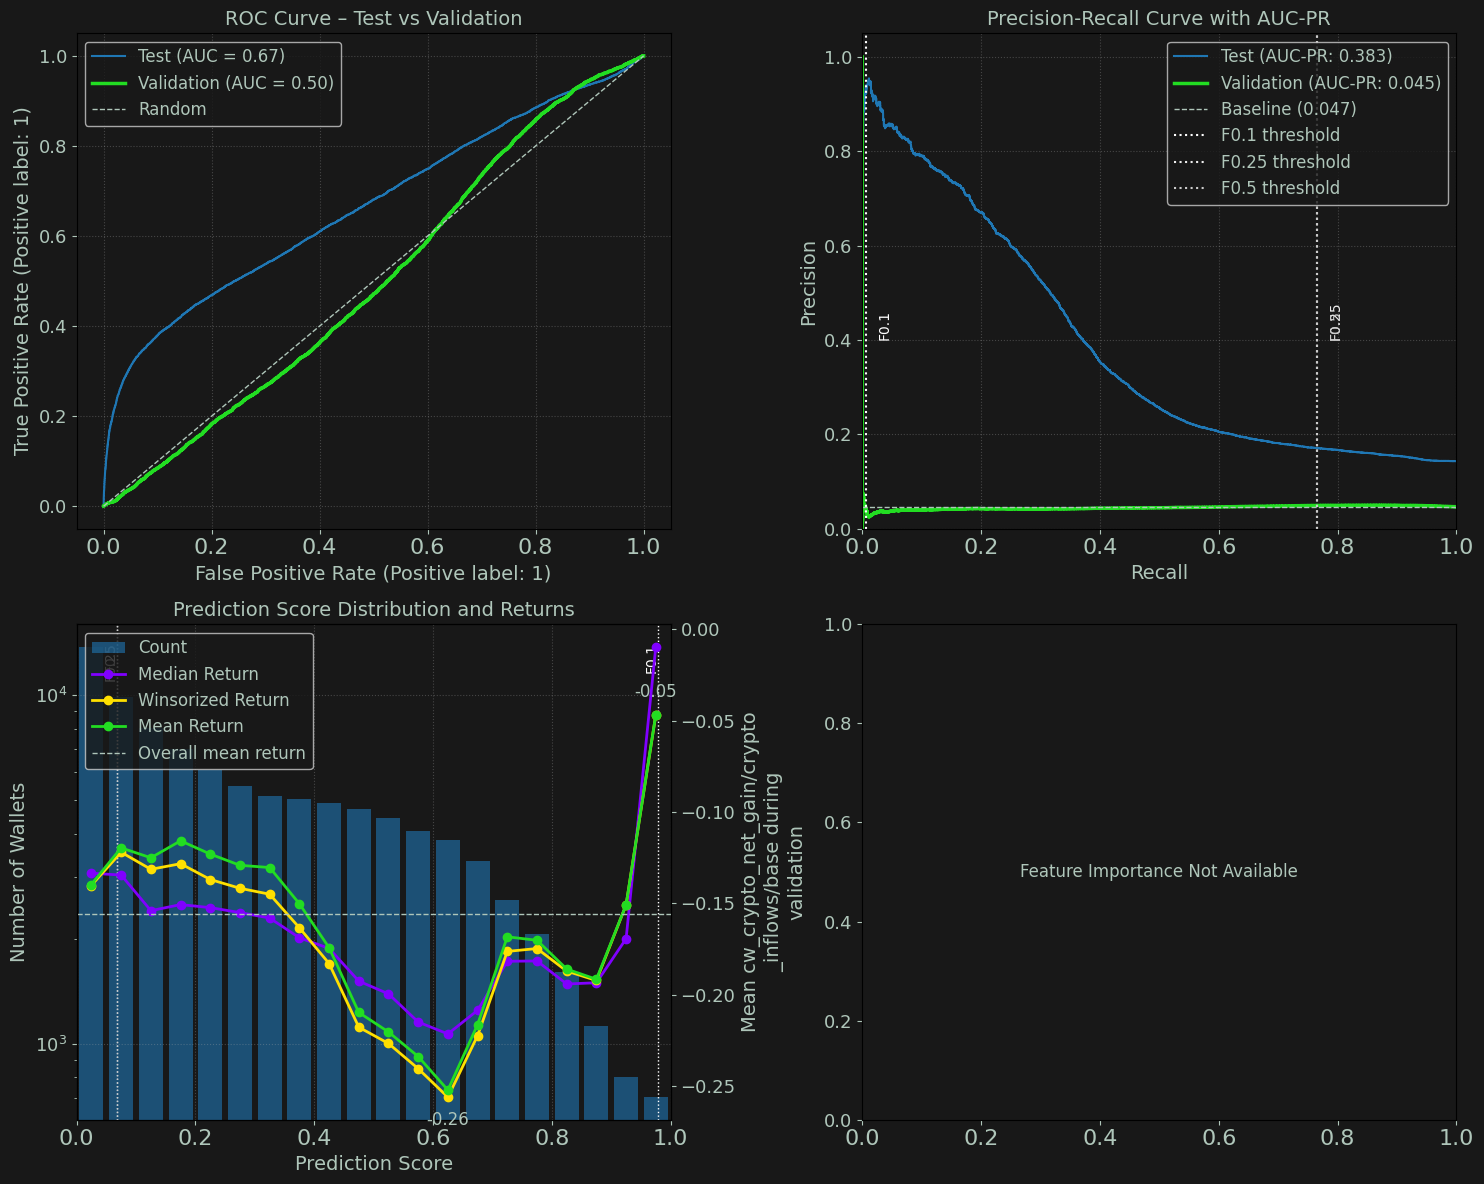

[13/Aug/25 17:44:17] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:17] WARNING [1138767417.<module>:5]                 60: 2024-08-03
[13/Aug/25 17:44:17] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:17] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-164642/output/model.tar.gz
Test Samples:             62,474
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.639
Val Accuracy:               0.755  |  0.808
Val Precision:              0.153  |  0.293
Val Recall:                 0.097  |  0.359
Val F1 Score:               0.119  |  0.322

Validation 

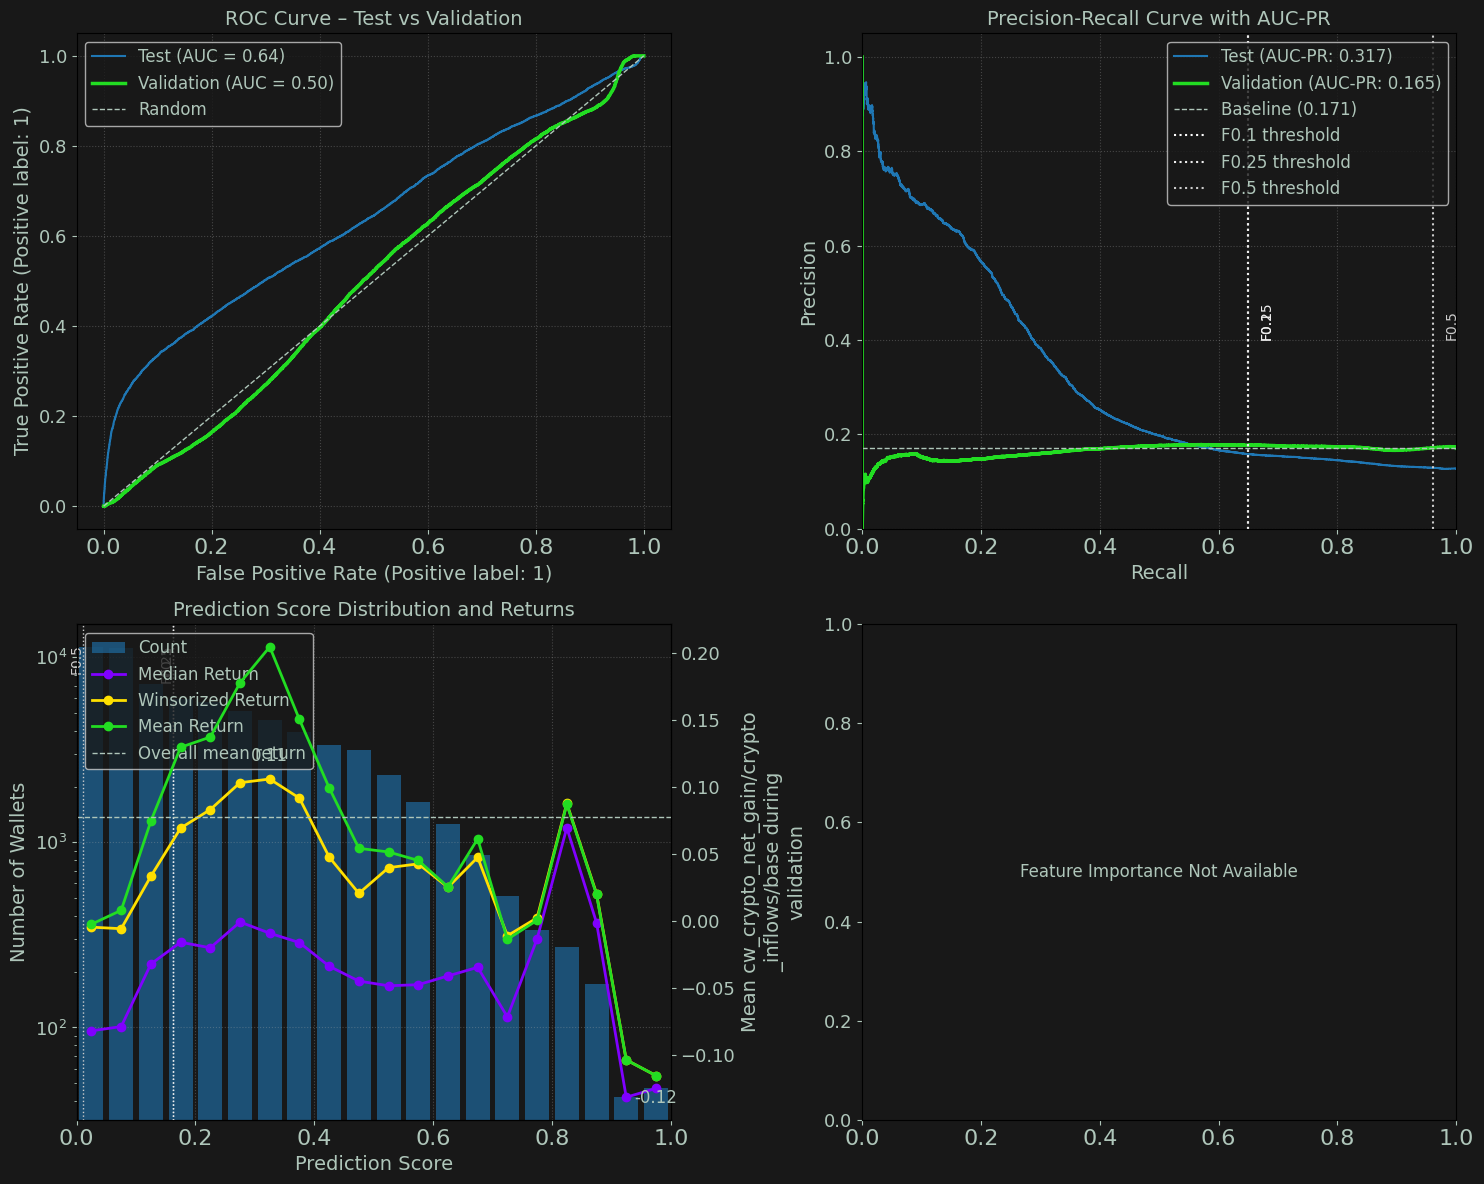

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 120: 2024-10-02
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-164642/output/model.tar.gz
Test Samples:             69,591
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.654
Val Accuracy:               0.663  |  0.826
Val Precision:              0.238  |  0.341
Val Recall:                 0.069  |  0.302
Val F1 Score:               0.107  |  0.320

Validati

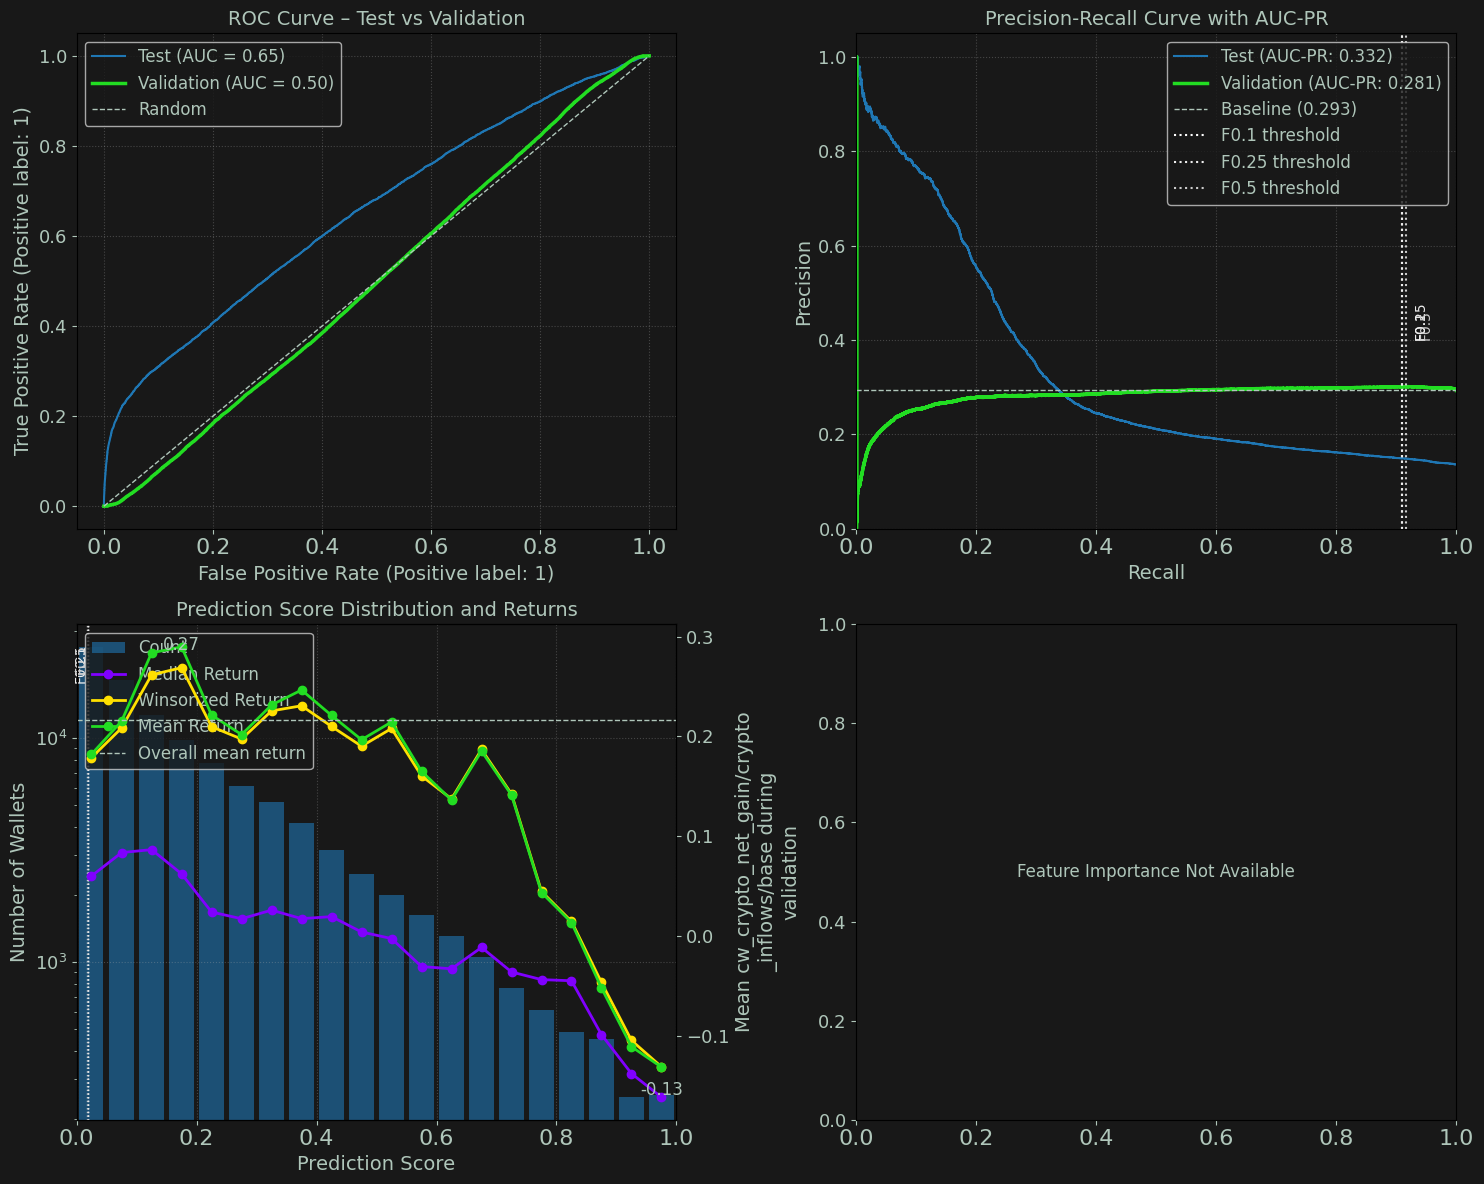

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 180: 2024-12-01
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-164642/output/model.tar.gz
Test Samples:             82,008
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.530  |  0.497
Val Accuracy:               0.734  |  0.742
Val Precision:              0.104  |  0.206
Val Recall:                 0.304  |  0.182
Val F1 Score:               0.155  |  0.193

Validatio

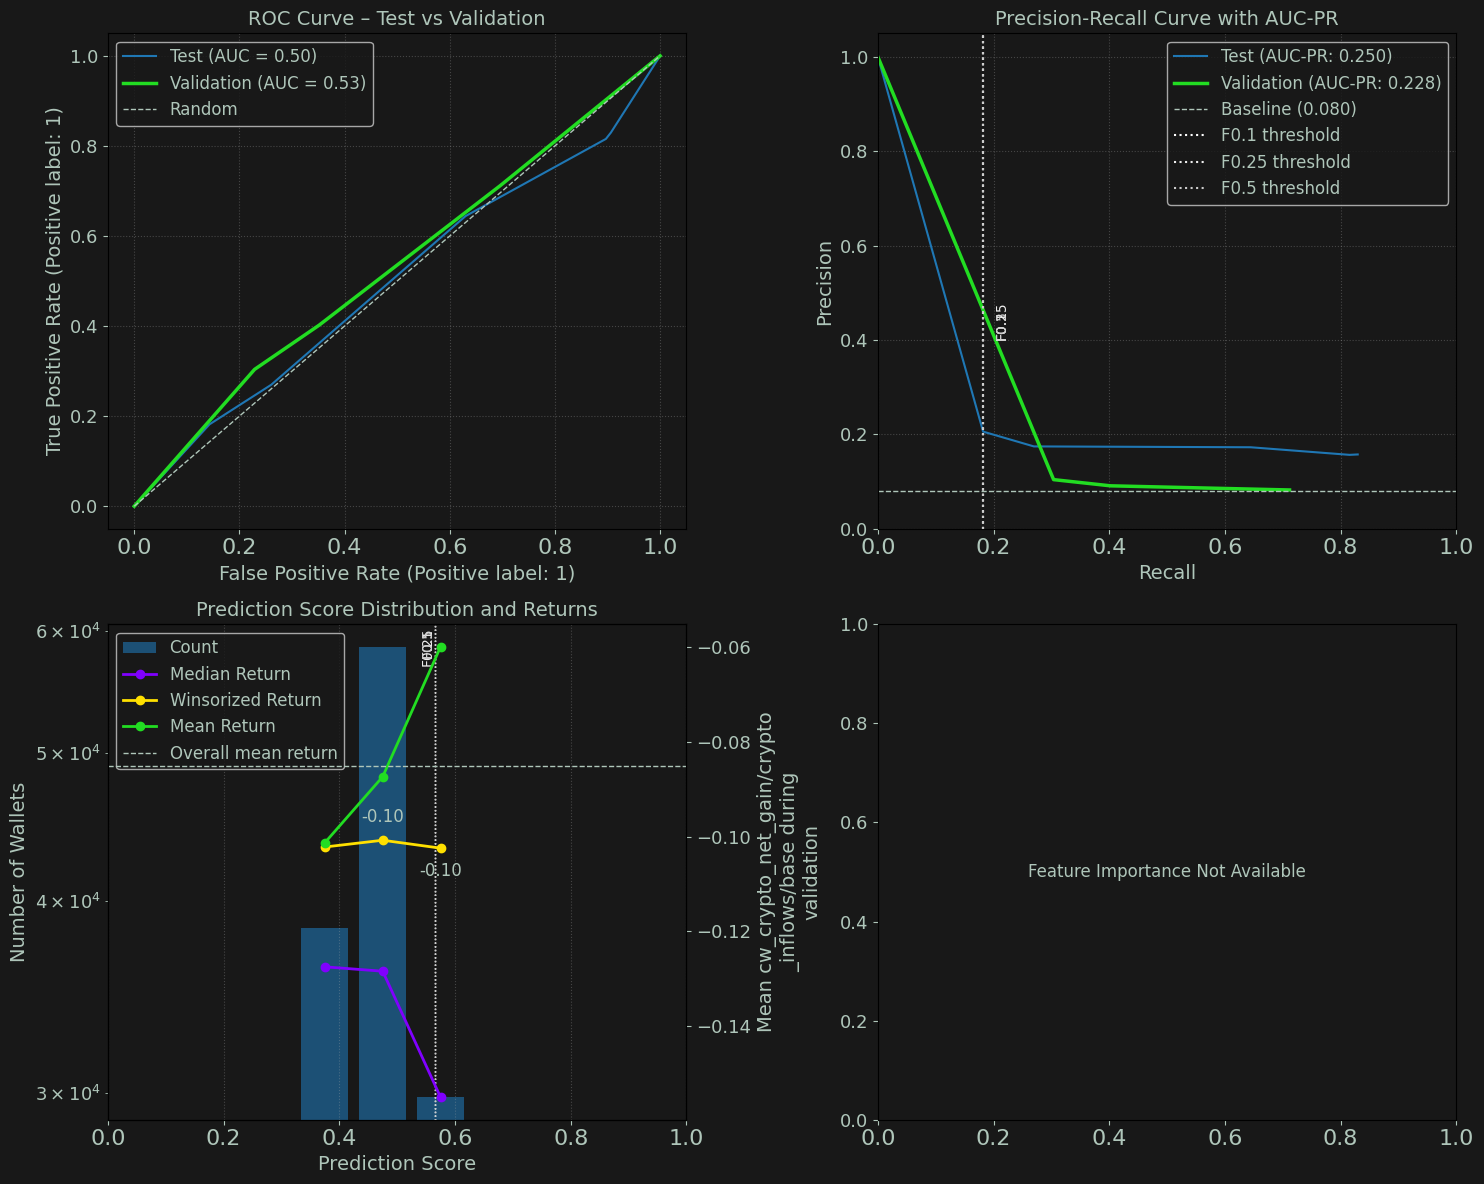

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 240: 2025-01-30
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-164642/output/model.tar.gz
Test Samples:             96,423
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.452  |  0.567
Val Accuracy:               0.297  |  0.550
Val Precision:              0.019  |  0.186
Val Recall:                 0.700  |  0.609
Val F1 Score:               0.036  |  0.285

Validation

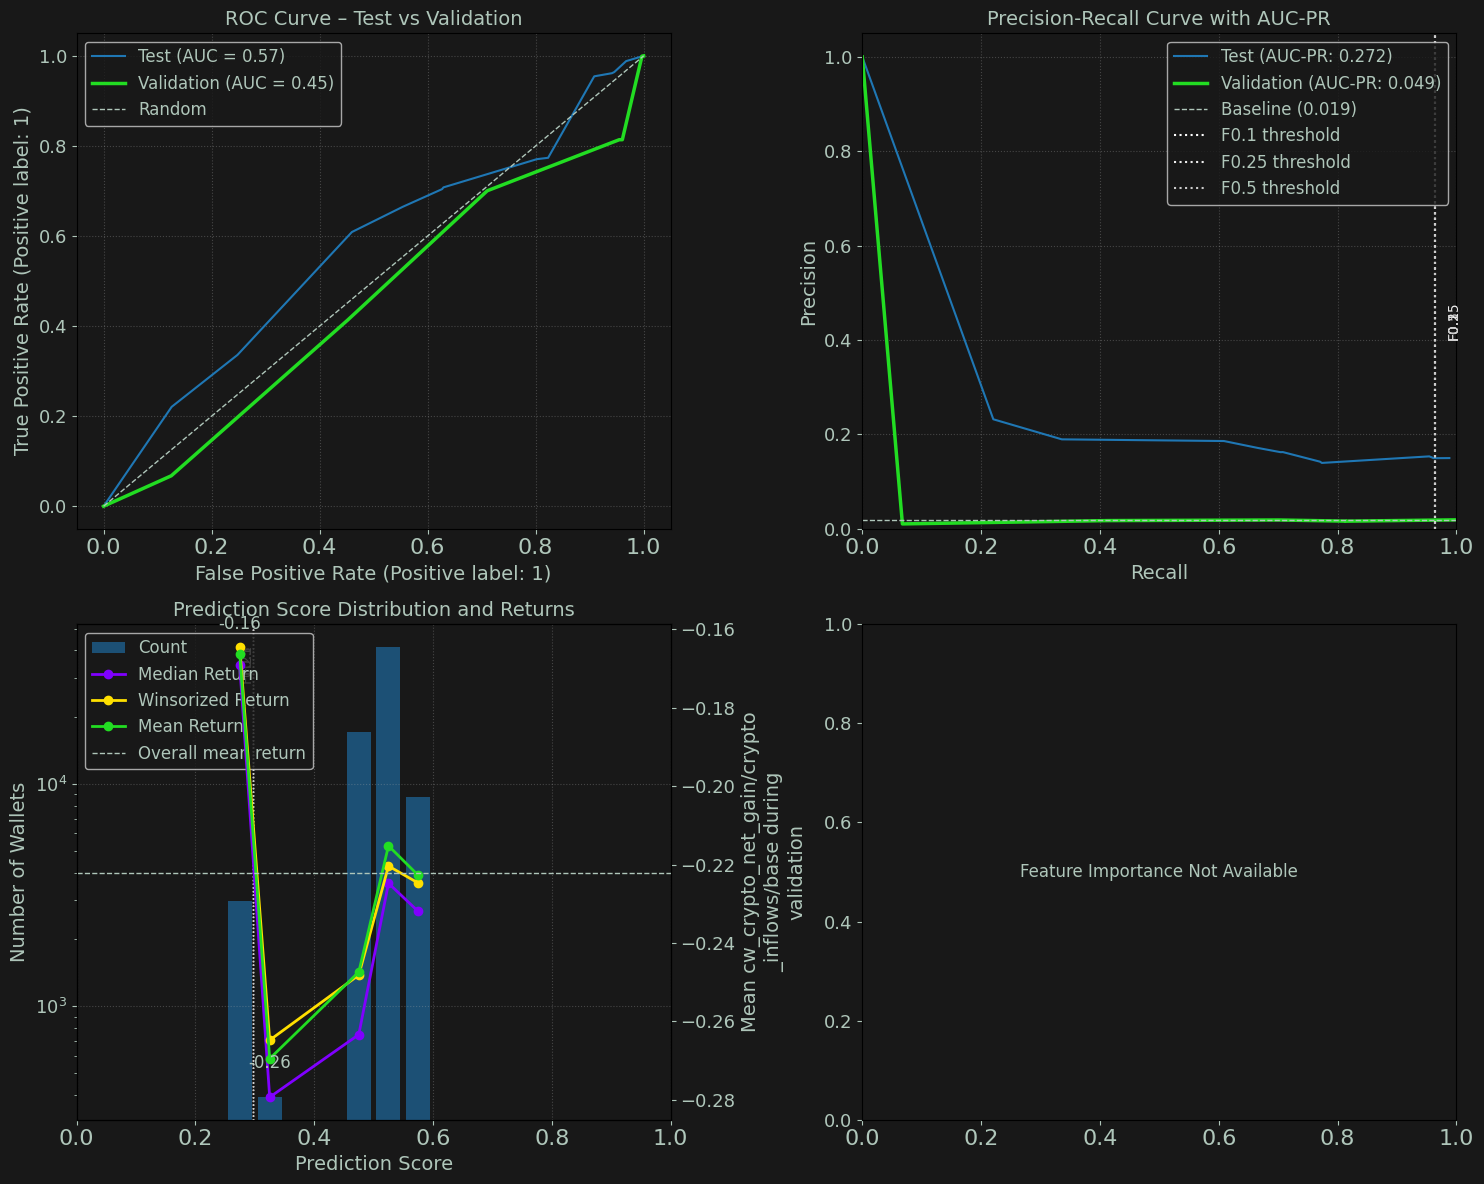

[13/Aug/25 17:44:19] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:19] WARNING [1138767417.<module>:5]                 300: 2025-03-31
[13/Aug/25 17:44:19] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:19] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-164642/output/model.tar.gz
Test Samples:             98,144
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.539  |  0.539
Val Accuracy:               0.548  |  0.645
Val Precision:              0.182  |  0.165
Val Recall:                 0.412  |  0.386
Val F1 Score:               0.252  |  0.231

Validatio

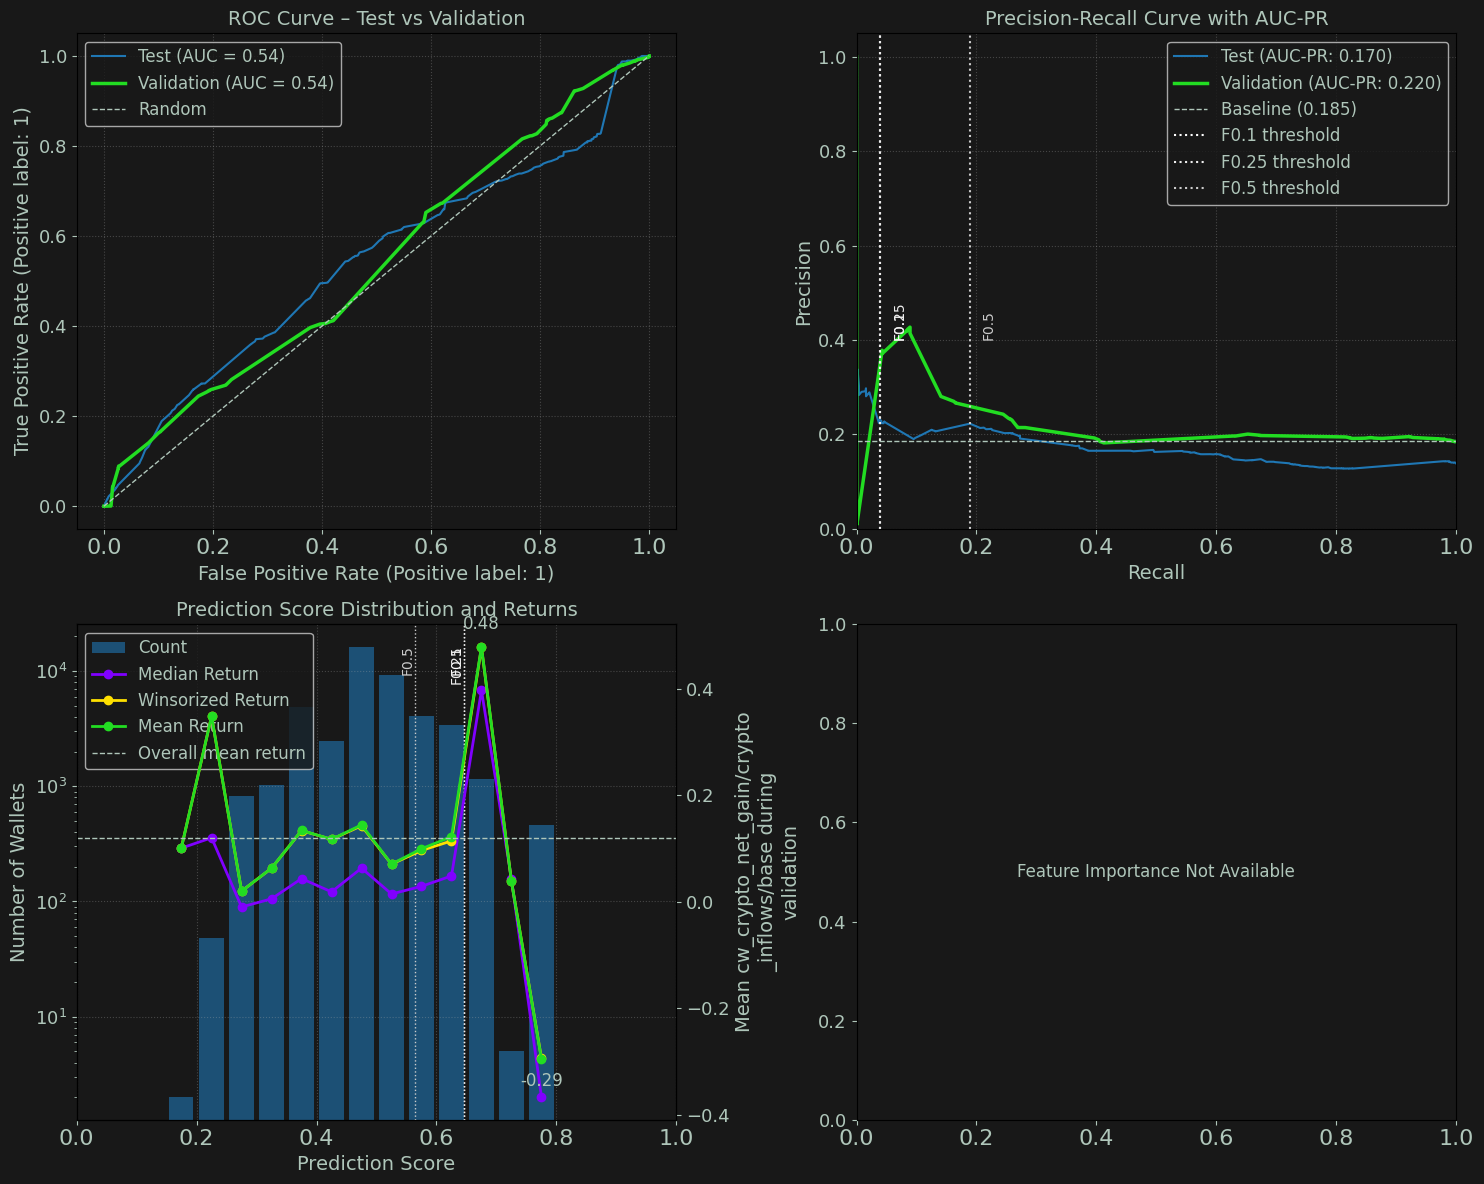

[13/Aug/25 17:44:19] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:19] WARNING [1138767417.<module>:5]                 360: 2025-05-30
[13/Aug/25 17:44:19] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:19] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-164642/output/model.tar.gz
Test Samples:             87,938
Val Positive Samples:     6,688 (15.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.610  |  0.587
Val Accuracy:               0.246  |  0.277
Val Precision:              0.167  |  0.121
Val Recall:                 0.974  |  0.860
Val F1 Score:               0.286  |  0.212

Validatio

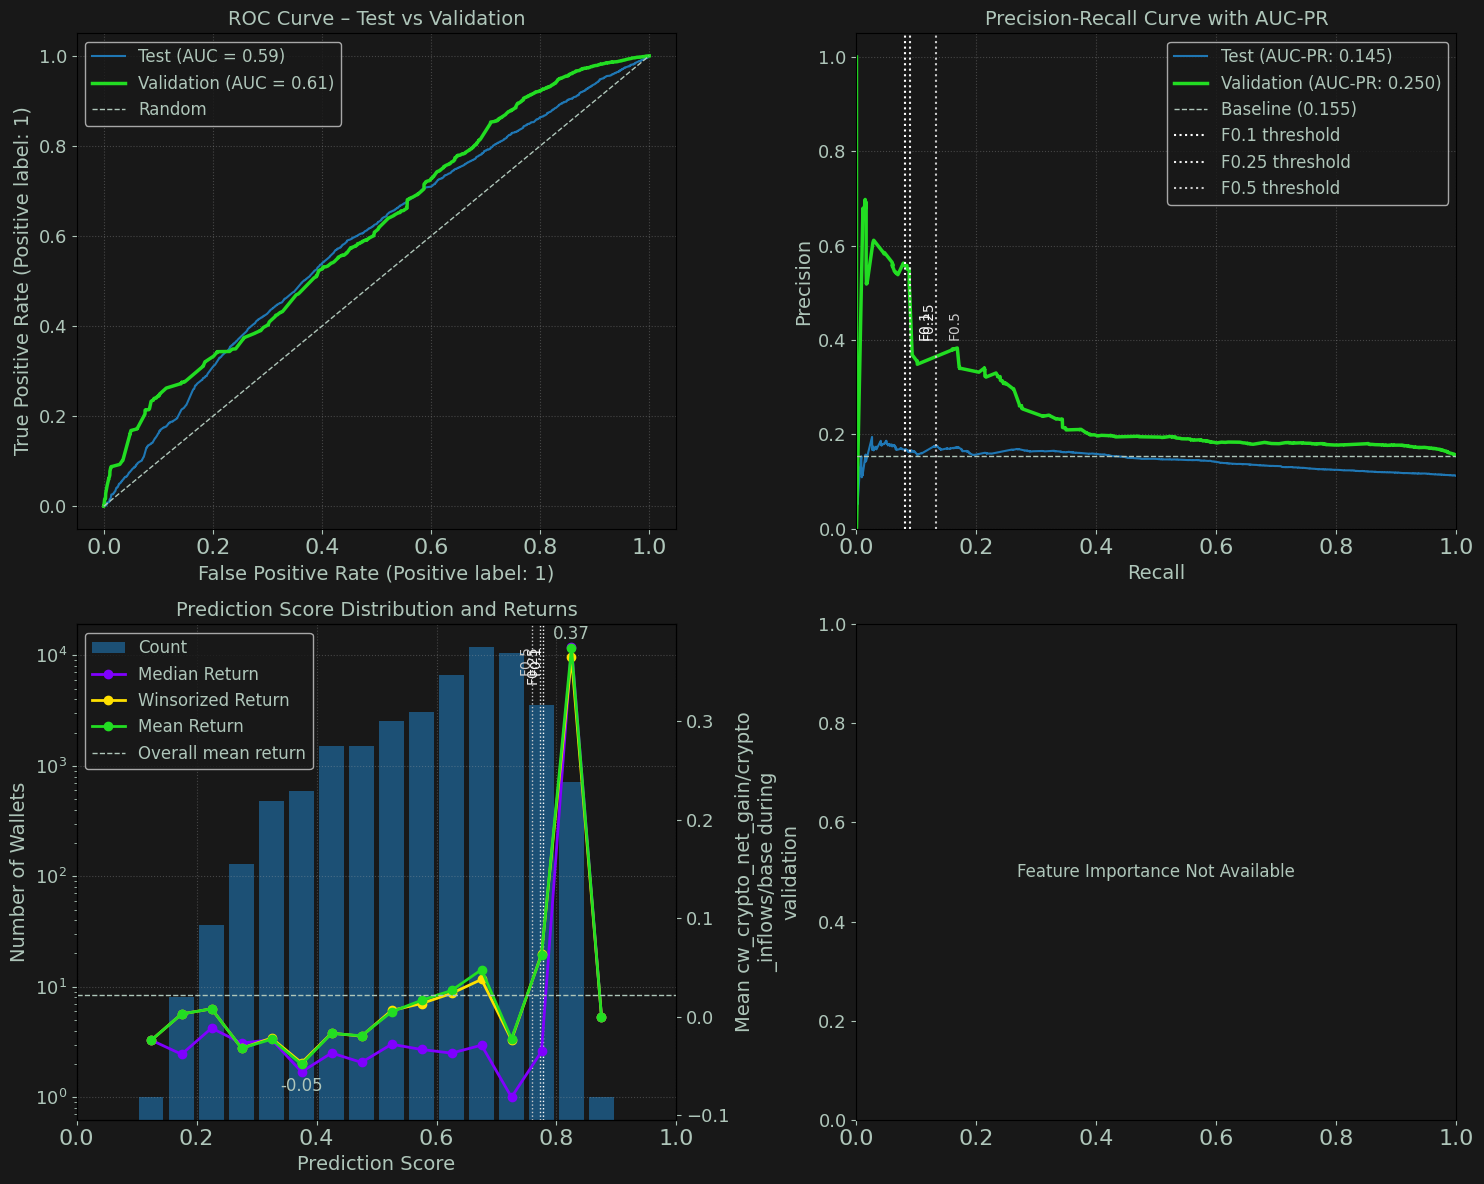

In [73]:
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable